<img src="https://news.illinois.edu/files/6367/543635/116641.jpg" alt="University of Illinois" width="250"/>

# Feed Forward Networks (Part 4)#
By Richard Sowers
* <r-sowers@illinois.edu>
* <https://publish.illinois.edu/r-sowers/>

Copyright 2020 University of Illinois Board of Trustees. All Rights Reserved.

# imports and graphics configurations #

In [ ]:
import torch
import numpy
import matplotlib
#%matplotlib notebook
import matplotlib.pyplot as plt
import scipy.stats
#from pandas.plotting import autocorrelation_plot
import matplotlib.offsetbox as offsetbox
from matplotlib.ticker import StrMethodFormatter
import graphviz
import itertools
import time

def saver(fname):
    plt.savefig(fname+".png",bbox_inches="tight")

def legend(pos="bottom",ncol=3):
    if pos=="bottom":
        plt.legend(bbox_to_anchor=(0.5,-0.2), loc='upper center',facecolor="lightgray",ncol=ncol)
    elif pos=="side":
        plt.legend(bbox_to_anchor=(1.1,0.5), loc='center left',facecolor="lightgray",ncol=1)

def textbox(txt,fname=None):
    plt.figure(figsize=(1,1))
    plt.gca().add_artist(offsetbox.AnchoredText("\n".join(txt), loc="center",prop=dict(size=30)))
    plt.axis('off')
    if fname is not None:
        saver(fname)
    plt.show()
    plt.close()

In [ ]:
#for some reason, this needs to be in a separate cell
params={
    "font.size":15,
    "lines.linewidth":5
}
plt.rcParams.update(params)

# configuration variables #

In [ ]:
SEED=0
N_points=100

In [ ]:
x_min=-3
x_max=3
markersize=5
thinlinewidth=2
textboxsize=(5,0.5)

# Generate training data in the plane #

points in the first and third quadrantes will have label 1
points in the second and fourth quadrants will have label 0

In [ ]:
xy=scipy.stats.norm.rvs(size=(N_points,2),random_state=SEED)

In [ ]:
flags=((xy[:,0]>0)&(xy[:,1]>0))|((xy[:,0]<0)&(xy[:,1]<0))
xy=numpy.array(xy,dtype=numpy.float32)
z=numpy.array(flags,dtype=numpy.float32).reshape(-1,1)

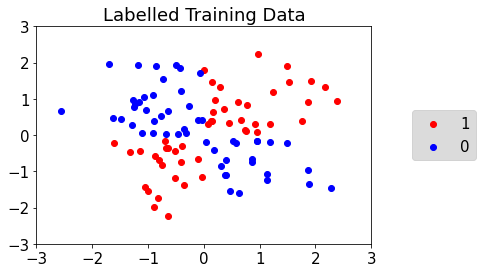

In [ ]:
plt.figure()
plt.scatter(xy[flags,0],xy[flags,1],color="red",label="1")
plt.scatter(xy[~flags,0],xy[~flags,1],color="blue",label="0")
plt.xlim(x_min,x_max)
plt.ylim(x_min,x_max)
title=[]
title.append("Labelled Training Data")
plt.title("\n".join(title))
legend("side")
#saver("tt_123")
plt.show()
plt.close()

feature-label pairs $\left\{((x_n,y_n),z_n)\right\}_{n=1}^N\subset \mathbb{R}^2\times \{0,1\}$.
Sigmoid function is
$$S(z)=\frac{1}{1+e^{-z}}$$
Model is
$$ S\left(M^{(3)}S\left(M^{(2)}S\left(M^{(1)}\begin{pmatrix} x \\ y \end{pmatrix} + B^{(1)}\right)+B^{(2)}\right)+B^{(3)}\right)$$
where
* $M^{(1)}\in \mathbb{R}^{2\times 2}$
* $B^{(1)}\in \mathbb{R}^2$
* $M^{(2)}\in \mathbb{R}^{2\times 2}$
* $B^{(2)}\in \mathbb{R}^2$
* $M^{(3)}\in \mathbb{R}^{1\times 2}$
* $B^{(3)}\in \mathbb{R}$



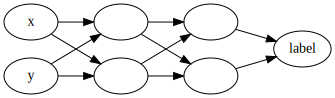

In [ ]:
g=graphviz.Digraph()
g.attr(rankdir='LR')
features=["x","y"]
for feature in features:
    g.node(feature)
a1=["a11","a12"]
for node in a1:
    g.node(node,label="")
for f,node in itertools.product(features,a1):
    g.edge(f,node)
a2=["a21","a22"]
for node in a2:
    g.node(node,label="")
for node1,node2 in itertools.product(a1,a2):
    g.edge(node1,node2)
labels=["label"]
for label in labels:
    g.node(label)
for (i2,l) in itertools.product(a2,labels):
    g.edge(i2,l)

g

# PyTorch #

In [ ]:
inputs=torch.from_numpy(xy)
labels=torch.from_numpy(z)

if torch.cuda.is_available():
    print("cuda is available")
    inputs = inputs.cuda()
    labels = labels.cuda()

In [ ]:
class SimpleFeedForward(torch.nn.Module):
    def __init__(self,SEED=0): #default to one-dimensional feature and response
        if SEED is not None:
          torch.manual_seed(SEED)
        super().__init__() #run init of torch.nn.Module
        self.linear1 = torch.nn.Linear(2,2)
        self.linear2 = torch.nn.Linear(2,2)
        self.linear3 = torch.nn.Linear(2,1)
        self.sigmoid=torch.nn.Sigmoid()
        if torch.cuda.is_available():
          self=self.cuda()

    def setweights(self,weight1=None,bias1=None,weight2=None,bias2=None,weight3=None,bias3=None):
      if weight1 is not None:
        self.linear1.weight.data=weight1
      if bias1 is not None:
        self.linear1.bias.data=bias1
      if weight2 is not None:
        self.linear2.weight.data=weight2
      if bias2 is not None:
        self.bias2.data=bias2
      if weight3 is not None:
        self.linear3.weight.data=weight3
      if bias3 is not None:
        self.bias3.data=bias3

    def forward(self, x,quantize=False):
        out=self.linear1(x) #a1
        out=self.sigmoid(out)
        out=self.linear2(out) #a2
        out=self.sigmoid(out)
        out=self.linear3(out)
        out=self.sigmoid(out)
        if quantize:
          out=self.quantizer(out)
        return out

    def quantizer(self,probabilities):
      return (probabilities>0.5).to(torch.float)

In [ ]:
def explore_initial_weights(initialweights,learningRate=1,MAX_iter=1000):
  model=SimpleFeedForward()
  model.setweights(weight1=torch.from_numpy(numpy.array(initialweights,dtype=numpy.float32)))
  Loss = torch.nn.BCELoss()
  losses=[]
  errors=[]
  optimizer = torch.optim.SGD(model.parameters(), lr=learningRate) #gradient descent
  tic=time.perf_counter()
  for ctr in range(MAX_iter):

    # Clear gradient buffers because we don't want any gradient from previous epoch to carry forward, dont want to cummulate gradients
    optimizer.zero_grad()

    # get output from the model, given the inputs
    outputs = model(inputs)

    # get loss for the predicted output
    lossvalue = Loss(outputs, labels)
    error=(model.quantizer(outputs)==1)!=(labels==1)
    errors.append(error.to(torch.float).mean())
    losses.append(lossvalue.detach().numpy())

    # get gradients w.r.t to parameters
    lossvalue.backward()
    #print(model.linear.weight.grad.item(),model.linear.bias.grad.item())

    # update parameters
    optimizer.step()
    if ctr%int(MAX_iter/10)==0: #print out data for 10 intermediate steps
      print("iteration {}: loss={:.5f}".format(ctr, lossvalue.item()))
  toc=time.perf_counter()

  print("\n")
  print("M^{(1)}=\n",model.linear1.weight.data.cpu().numpy(),"\nB^{(1)}=",model.linear1.bias.data.cpu().numpy())
  print("\n")
  print("M^{(2)}=\n",model.linear2.weight.data.cpu().numpy(),"\nB^{(2)}=",model.linear2.bias.data.cpu().numpy())
  print("\n")
  print("M^{(3)}=\n",model.linear3.weight.data.cpu().numpy(),"\nB^{(3)}=",model.linear3.bias.data.cpu().numpy())
  dt=toc-tic


  return model,losses,errors,dt

In [ ]:
def visualizer(model,losses,errors,dt):
  outputs=model(inputs,quantize=True).detach().numpy()
  flags_correct=1-numpy.abs(labels-outputs)
  accuracy=flags_correct.mean()
  flags=outputs.flatten()==1
  plt.figure()
  plt.scatter(xy[flags,0],xy[flags,1],color="red",label="1")
  plt.scatter(xy[~flags,0],xy[~flags,1],color="blue",label="0")
  title=[]
  title.append("Computed Labels on Training Data")
  title.append("Accuracy={:.1%}".format(accuracy))
  plt.title("\n".join(title))
  plt.xlim(x_min,x_max)
  plt.ylim(x_min,x_max)
  legend("side")
  #saver("tt_123")
  plt.show()
  plt.close()

  plt.figure()
  plt.plot(losses,color="red")
  plt.xlabel("Iteration")
  plt.ylabel("loss")
  plt.ylim(-0.1,)
  title=[]
  title.append("Losses")
  title.append("Elapsed time: {0:.02f} seconds".format(dt))
  plt.title("\n".join(title))
  plt.axhline(0,linewidth=2,linestyle=":",color="black")
  plt.show()
  plt.close()

  plt.figure()
  plt.plot(errors,color="red")
  plt.xlabel("Iteration")
  plt.ylabel("percent wrong")
  plt.ylim(-0.05,)
  plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:.1%}'))
  plt.axhline(0,linewidth=2,linestyle=":",color="black")
  title=[]
  title.append("Classification Errors")
  title.append("Elapsed time: {0:.02f} seconds".format(dt))
  plt.title("\n".join(title))
  plt.show()
  plt.close()

In [ ]:
m,losses,errors,dt=explore_initial_weights([[1,0],[0,0]],MAX_iter=25000)

iteration 0: loss=0.76746
iteration 2500: loss=0.56589
iteration 5000: loss=0.56394
iteration 7500: loss=0.03774
iteration 10000: loss=0.00464
iteration 12500: loss=0.00225
iteration 15000: loss=0.00146
iteration 17500: loss=0.00107
iteration 20000: loss=0.00084
iteration 22500: loss=0.00069


M^{(1)}=
 [[14.116726    0.5018015 ]
 [ 0.20829506 12.7440815 ]] 
B^{(1)}= [ 0.09642127 -0.07278337]


M^{(2)}=
 [[-11.705883  10.778421]
 [ -9.275299   9.442327]] 
B^{(2)}= [-3.4231248  3.7661684]


M^{(3)}=
 [[-17.51917   16.439692]] 
B^{(3)}= [-7.62651]


In [ ]:
#@title
M1=m.linear1.weight.data
b1=m.linear1.bias.data.squeeze()
M2=m.linear2.weight.data
b2=m.linear2.bias.data.squeeze()
M3=m.linear3.weight.data.squeeze()
b3=m.linear3.bias.data.item()
eps_recip=M1.diag().mean()
epsprime_recip=M2.abs().mean()
offsetprime=b2.abs().mean()/epsprime_recip
epsprimeprime_recip=M3.abs().mean()
ofsetprimeprime=b3/epsprimeprime_recip
print("eps=1/{0:.1f}, epsprime={1:.1f}, offsetprime={2:.1f}, epsprimeprime={3:.1f}, offsetprimeprime={4:.1f}".format(eps_recip,epsprime_recip,offsetprime,
                                                                    epsprimeprime_recip,ofsetprimeprime))
#print("eps=1/{0:.1f}, epsprime=1/{1:.1f}, offsetprime={2:.2f}".format(eps_recip,epsprime_recip,offsetprime))

eps=1/13.4, epsprime=10.3, offsetprime=0.3, epsprimeprime=17.0, offsetprimeprime=-0.4


First layer: approximately
$$S\left(M^{(1)}\begin{pmatrix} x \\ y \end{pmatrix}+B^{(1)}\right)\approx \begin{pmatrix} s_\varepsilon(x)\\ s_\varepsilon(y)\end{pmatrix}$$
with $\varepsilon\approx 1/13.4$.

Second layer:  approximately
$$S\left(M^{(2)}S\left(M^{(1)}\begin{pmatrix} x \\ y \end{pmatrix} +B^{(1)}\right)+B^{(2)}\right)\approx \begin{pmatrix} s_\varepsilon(-s_\varepsilon(x)+s_\varepsilon(y)-0.3)\\ s_\varepsilon(-s_\varepsilon(x)+s_\varepsilon(y)+0.3)\end{pmatrix} \\
\approx \begin{pmatrix} 1_{Q2}(x,y) \\ 1_{Q1+Q2+Q3}(x,y)\end{pmatrix}$$
with $\varepsilon'\approx 1/10.3$

Third layer:  approximately
$$S\left(M^{(3)}S\left(M^{(2)}S\left(M^{(1)}\begin{pmatrix} x \\ y \end{pmatrix} +B^{(1)}\right)+B^{(2)}\right)+B^{(3)}\right)
\approx S\left(-17\times 1_{Q2}(x,y)+17\times 1_{Q1+Q2+Q3}(x,y)-7.6\right)\\
\approx S_{\varepsilon^{\prime \prime}}\left(1_{Q1+Q3}(x,y)-0.4\right)$$
with $\varepsilon^{\prime \prime}\approx 17.0$

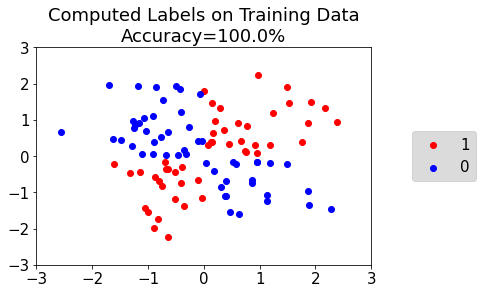

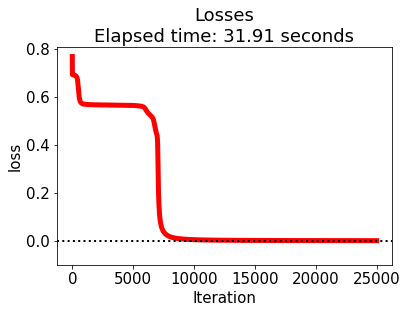

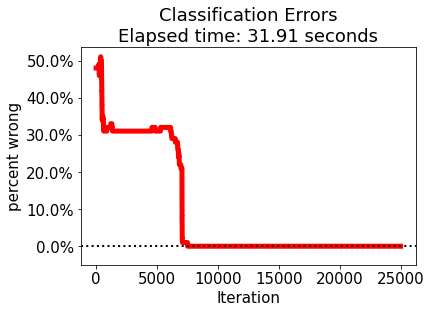

In [ ]:
visualizer(m,losses,errors,dt)

In [ ]:
m,losses,errors,dt=explore_initial_weights([[0,0],[1,0]],MAX_iter=25000)

iteration 0: loss=0.76948
iteration 2500: loss=0.44225
iteration 5000: loss=0.44049
iteration 7500: loss=0.44230
iteration 10000: loss=0.44123
iteration 12500: loss=0.44020
iteration 15000: loss=0.43960
iteration 17500: loss=0.43927
iteration 20000: loss=0.43875
iteration 22500: loss=0.43696


M^{(1)}=
 [[ 2.849212  -2.7539043]
 [ 1.9629565 -1.464426 ]] 
B^{(1)}= [-4.071521  2.218327]


M^{(2)}=
 [[-6.0411563  5.085968 ]
 [ 6.551706  -6.882248 ]] 
B^{(2)}= [-5.4573994  0.5094333]


M^{(3)}=
 [[  8.559732 -11.000212]] 
B^{(3)}= [-0.57368994]


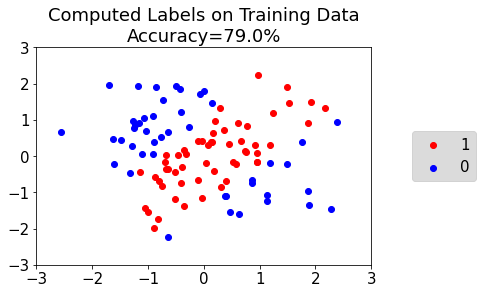

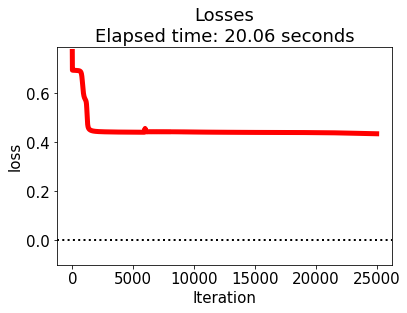

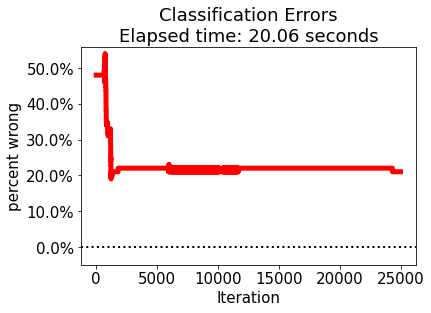

In [ ]:
visualizer(m,losses,errors,dt)